In [1]:
import gym
import numpy as np
import random
import torch
from itertools import count


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

device

device(type='cuda')

In [4]:
from collections import deque

class Memory():
    def __init__(self, capacity=10000, short_capacity=2000):
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)
        self.short_memory = deque(maxlen=short_capacity)
        
    def push(self, old_state, action, reward, new_state, final):
        self.short_memory.append([old_state, action, reward, new_state, final])
        
    def commit(self, final=True): 
        self.short_memory[-1][-1] = final
        self.memory.extendleft(self.short_memory)
        self.short_memory.clear()

In [5]:
# class Memory():
#     def __init__(self, capacity=10000):
#         self.capacity = capacity
#         self.memory = []
#         self.short_memory = []
        
#     def push(self, old_state, action, reward, new_state, final):
#         self.short_memory.append([old_state, action, reward, new_state, final])
        
#     def commit(self, final=True): 
#         if len(self.memory) + len(self.short_memory) < self.capacity:
#             self.memory.extend(self.short_memory)
#         else:
#             for memo in self.short_memory:
#                 self.memory.insert(random.randint(0, len(self.memory) - 1), memo)
                
#         self.memory = self.memory[:self.capacity]
#         self.short_memory = []

In [6]:
class Qnet(torch.nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(4, 32),
#             torch.nn.LeakyReLU(inplace=True),
#             torch.nn.Linear(32, 32),
            torch.nn.LeakyReLU(inplace=True),
            torch.nn.Linear(32, 2),
#             torch.nn.Sigmoid(),
        #     torch.nn.Softmax(dim=1),
        )
    
    def forward(self, x):
        return self.model(x)

In [12]:
class Agent:
    def __init__(self, observation_space=None, action_space=None, device=None):
        self.device = device
        
        self.reset()
    
    def reset(self):
        self._mode = 'train'
        self._episode_count = 0
        self._eps = 0.99999
        self._eps_min = 0.01
        self._gamma = 0.99999
        
        self.policy_net = Qnet().to(self.device)
        self.target_net = Qnet().to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optim = torch.optim.Adam(self.policy_net.parameters(), lr=0.05)
        
        self.memory = Memory(capacity=10000000)  
    
    def push_observation(self, old_state, action, reward, state, final):
        self.memory.push(old_state, action, reward, state, final)
    
    def episode_ended(self):
        self.memory.commit()
        self._episode_count += 1
        
    def get_action(self, state):
        def get_model_action(state):
            with torch.no_grad():
                input = torch.FloatTensor(state).to(self.device)
                model_output = self.policy_net(input.unsqueeze(0))
                model_output = model_output.cpu().detach().numpy()
                return np.argmax(model_output[0])
            
        if self._mode == 'eval':
            return get_model_action(state)
        if self._mode == 'train':
            self._eps *= self._gamma
            self._eps = max(self._eps, self._eps_min)
            if random.random() > self._eps:
                return get_model_action(state)
            else:
                return random.randint(0, 1)
        raise "unknown mode"
        
    def train_memory(self):
        memory = self.memory.memory
        try:
            memory = random.sample(memory, 512)
        except ValueError:
            return

        s0 = [x[0] for x in memory]
        a = [x[1] for x in memory]
        r = [x[2] for x in memory]
        s1 = [x[3] for x in memory]
        done = [1. if x[4] else 0. for x in memory]


        s0 = torch.FloatTensor(s0).to(self.device)
        s1 = torch.FloatTensor(s1).to(self.device)
        a = torch.LongTensor(a).to(self.device)
        r = torch.FloatTensor(r).to(self.device)
        done = torch.FloatTensor(done).to(self.device)

        q_values = self.policy_net(s0)
        next_q_values = self.target_net(s1)
        next_q_value = next_q_values.max(1)[0]

        q_value = q_values.gather(1, a.unsqueeze(1)).squeeze(1)
        expected_q_value = r + 0.999 * next_q_value * (1.0 - done)
        # Notice that detach the expected_q_value
        loss = (expected_q_value.detach() - q_value).pow(2).mean()

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
        
        
        if self._episode_count % 10 == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())
  
    def train(self):
        self._mode = 'train'
    def eval(self):
        self._mode = 'eval'

In [13]:
env = gym.make('CartPole-v0')
env._max_episode_steps = 2000

In [14]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [15]:
agent = Agent(observation_space=4, action_space=2, device=device)
agent.train()

In [16]:
len_mem = []
try:
    for episode in range(100000):
        state = env.reset()

        for i in count():
#             env.render()

#             action = get_model_action(policy_net, state, device)
            action = agent.get_action(state)
            old_state = state
            state, reward, done, info = env.step(action)

            if done:
                env.close()
                len_mem.append(i)
                
                if abs(i-2000) < 10:
                    reward = 1
                    final = False
                else:
                    reward = -5
                    final = True
                
                agent.push_observation(old_state, action, reward, state, final)
                agent.episode_ended()
                break
            else:
                agent.push_observation(old_state, action, reward, state, False)
        
        if episode % 100 == 0:
            print('Episode {:3d}: {:10.3f} iterations, eps={:6.6f}'.format(episode, 
                                                                           np.mean(len_mem[-100:]), 
                                                                           agent._eps))
        agent.train_memory()
    
except KeyboardInterrupt:
    env.close()

Episode   0:     26.000 iterations, eps=0.999720
Episode 100:     19.830 iterations, eps=0.979111
Episode 200:     23.220 iterations, eps=0.955682
Episode 300:     24.180 iterations, eps=0.931918
Episode 400:     26.870 iterations, eps=0.906304
Episode 500:     33.090 iterations, eps=0.875929
Episode 600:     29.950 iterations, eps=0.849234
Episode 700:     28.360 iterations, eps=0.824663
Episode 800:     37.630 iterations, eps=0.793413
Episode 900:     43.500 iterations, eps=0.758880
Episode 1000:     48.100 iterations, eps=0.722519
Episode 1100:     53.100 iterations, eps=0.684469
Episode 1200:     72.270 iterations, eps=0.636111
Episode 1300:     61.790 iterations, eps=0.597397
Episode 1400:     84.870 iterations, eps=0.548240
Episode 1500:    110.750 iterations, eps=0.490273
Episode 1600:    164.060 iterations, eps=0.415674
Episode 1700:    155.370 iterations, eps=0.355502
Episode 1800:    159.410 iterations, eps=0.302814
Episode 1900:    167.730 iterations, eps=0.255798
Episode 20

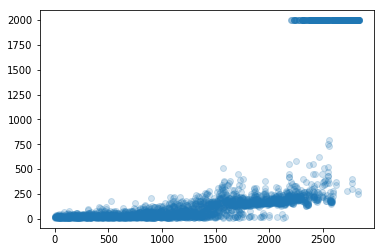

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(len_mem, 'o', alpha=0.2)

In [18]:
agent.eval()

try:
    env.seed = random.randint(0, 100000)
    obs = env.reset()
    env._max_episode_steps = 100000
    for t in count():
        
        if t % 500 == 0:
            print(t)
        
#         env.render()
        action = agent.get_action(obs)
        obs, reward, done, info = env.step(action)
        if done:
            env.close()
            break

    print(t)
except KeyboardInterrupt:
    pass
finally:
    env.close()
    print (t)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56211


In [12]:
model = policy_net

In [13]:
model.to('cpu')

Qnet(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [14]:
torch.save(model, 'model.torch')

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type Qnet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [26]:
model = torch.load('model.torch')

In [27]:
model.to(device)

Qnet(
  (model): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace)
    (2): Linear(in_features=32, out_features=2, bias=True)
  )
)

In [28]:
policy_net = model